# Risk in The New York Times

> [Daniel McDonald](https://twitter.com/interro_gator)

## 1. Load modules and corpus into memory

In [20]:
# imports and settings
%matplotlib notebook
import seaborn as sns
import pandas as pd
from corpkit import *

# convert pos tags to word classes
from corpkit.dictionaries.word_transforms import taglemma

# set and load corpus
corpus = Corpus('/Users/danielmcdonald/work/risk/all/eng-parsed/NYT')
#loaded = corpus.load(load_trees=True)

# high performance storage for our data
savefile = '/Users/danielmcdonald/work/risk/all/nyt-results.h5'
saved = pd.HDFStore(savefile)

# a quick method to produce abs and relative frequency from result
pd.DataFrame.summary = lambda x, y=25: pd.DataFrame({'N': x.sum(), \
                       '%': x.sum() * 100 / x.sum().sum()})[['N', '%']].head(y)

# some general features of our corpus
# there is 1963 data in here, so let's forget about it
feat = corpus.features('year').drop(1963)

# configurable style for our figures
sty = {'tex': False,
       'alpha': 0.75,
       'x_label': 'Year',
       'black_and_white': False}

Now, we define our queries.

We make dictionaries of dependency queries and their save names, using `depgrep` syntax. We then iterate over the dictionary, performing the search on the corpus, and saving each result.

We get different risk processes through a similar method, too.

In [ ]:
# any risk lemma
riskwords = corpus.lemmas(r'\brisk')
saved.append('rskword', riskwords[['w', 'l', 'p', 'f', 'g', 'year']], format='table')

# a huge 
qs = {'adj_mod': r'f/amod/ <- l/\brisk/',                  # Adjectives modifying nominal risk: big risk
      'rsknoun': r'p/^N/ -> (f/amod/ = l/\brisk/)',        # Nouns modified by risk: risky business
      'nom_dep': r'p/^N/ <- (p/^V/ = l/\brisk/)',          # Nominal dependents of verbal risk: i risk, risk harm
      'nom_mod': r'p/^N/ -> (f/compound$/ = l/\brisk/)',   # risk as nominal modifier: risk management
      'nom_rsk': r'f/compound$/ <- l/\brisk/',             # risk as nominal modifier: health risk
      'rsk_dob': r'p/^V/ -> (f/dobj|nsubj:?pass/ = l/\brisk/)', # when risk is dobj, what is the verb: reduce risk
      'rsk_sbj': r'p/^V/ -> (f/nsubj$/ = l/\brisk/)',      # when risk is nsubj, what is the verb: risk is, risk has
      'riskers': r'f/nsubj$/ <- (p/^V/ = l/\brisk/)',      # riskers: i risk, you risk
      'riskeds': r'f/dobj/ <- (p/^V/ = l/\brisk/)',        # risked things/potential harms: risk life, risk death
      'r_t_rsk': r'f/nsubj$/ <- (p/^V/ = l/\brisk/) | <- (p/^V/ = l/\b(take|run)/ -> l/\brisk/)', # risker inc. take/run
      'at_risk': r'p/^N/ -> w/\bat-risk\b/'}

for name, query in qs.items():
    res = corpus.deps(query, multiprocess=3)
    #save(res, name)
    res = res[['w', 'l', 'p', 'f', 'g', 'year']]
    saved.append(name, res, format='table')

# risk processes: risk, take risk, run risk, pose risk, put at risk
out = {}
rproc = {'take risk': r'p/^V/ = l/\btake/ -> l/\brisk/',
         'run risk': r'p/^V/ = l/\brun/ -> l/\brisk/',
         'pose risk': r'p/^V/ = l/\bpose/ -> l/\brisk/',
         'put at risk': r'p/^V/ = l/\bput/ -> (f/nmod/ = l/\brisk/)',
         'risk': r'p/^V/ = l/\brisk/'}

for name, query in rproc.items():
    res = corpus.deps(query, multiprocess=3)
    out[name] = res.table(subcorpora='year').sum(axis=1)

# bring results together, sort by total frequency and save
df = pd.DataFrame(out)
df = df[df.sum().sort_values(ascending=False).index]
saved.append('rsk_prc', df, format='table')

# get all possible risked things and potential harm
risked = {'ob_r': r'f/dobj/ <- (p/^V/ = l/\brisk/)', # risk death
          'pp_of': r'f/nmod:(?:of|to)/ -> l/\brisk/', # risk of death, risk to life
          'put_r': r'f/dobj/ <- (l/^put$/ -> (f/nmod:at/ = l/\brisk/))', # put life at risk
          'compo': r'f/compound/ <- l/\brisk/', # the death risk
          'relpr': r'f/xcomp/ <- (l/^be$/ -> (f/nsubj$/ = l/\brisk/))' # risk was bad,
          'relob': r'f/nsubj$/ <- (l/^be$/ -> (f/xcomp/ = l/\brisk/))' # it was risk}

dfs = []
for name, query in risked.items():
    res = corpus.deps(query, multiprocess=3, no_store=True)
    dfs.append(res.table(subcorpora='year', show='l'))

df = pd.concat(dfs, axis=1).groupby(axis=1, level=0).sum()
df = df[df.sum().sort_values(ascending=False).index]
saved.append('potharm', df.T, format='table')

## 2. Result editing and visualisation

In [38]:
# here is the data we have stores away:
saved.keys()

['/adj_mod',
 '/at_risk',
 '/nom_dep',
 '/nom_mod',
 '/nom_rsk',
 '/potharm',
 '/r_t_rsk',
 '/riskeds',
 '/riskers',
 '/rsk_dob',
 '/rsk_prc',
 '/rsk_sbj',
 '/rsknoun',
 '/rskword']

### Frequency of risk words in the corpus

In [56]:
s = saved['rskword'].table(subcorpora='year').sum(axis=1)
#s.visualise(title="Risk words",y_label='Absolute frequency', **sty)

In [57]:
# relative frequency of risk words in the corpus
rel = s * 100 / feat['Words'].loc[1987:2014]
#rel.visualise(title="Risk words / all words", y_label='Relative frequency', **sty)

<IPython.core.display.Javascript object>


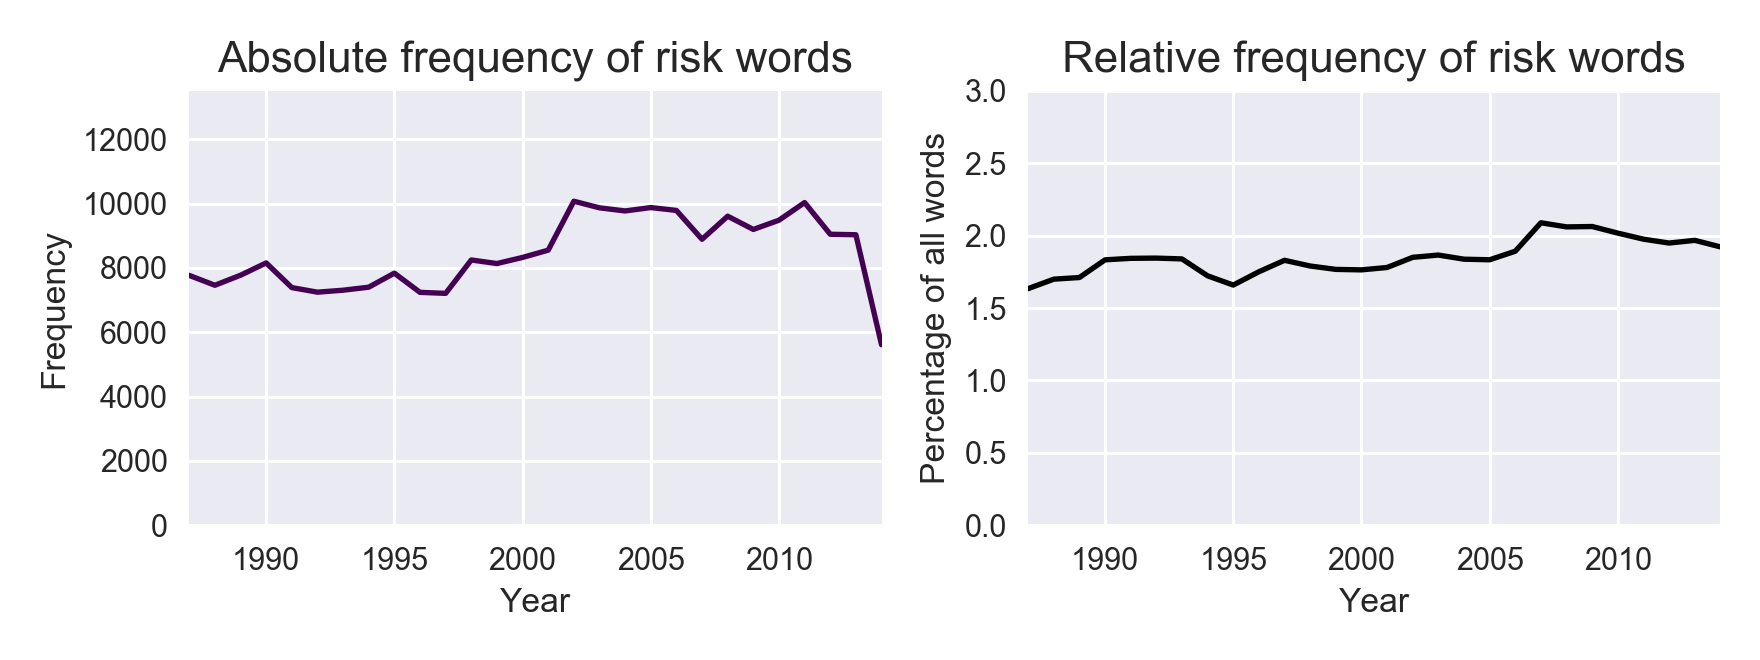

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [39]:
# the multiplot method takes two dicts, which style the left (main) and other plot(s)
s.multiplot({'kind': 'line',
             'title': 'Absolute frequency of risk words',
             'y_label': 'Frequency',
             'ylim': (0, 13500)},
            {'data': rel,
             'title': 'Relative frequency of risk words',
             'y_label': 'Percentage of all words',
             'ylim': (0, 3)},
            layout=1, figsize=(8,3), **sty)

### Word classes in corpus and for risk words

In [21]:
# make a wordclass column
loaded['wc'] = loaded['p'].apply(lambda x: taglemma.get(x.lower(), x).title()).astype('category')
# reduce to just open
crp = loaded[loaded['wc'].isin(['Adverb', 'Verb', 'Adjective', 'Noun'])]
# show by year
crp = crp.table(subcorpora='year', show='wc', relative=True, preserve_case=True)
#crp.visualise(title='Open word classes in the NYT corpus', kind='area', figsize=(7,7),
#              y_label='Percentage of all open class words', **sty)

In [22]:
# word classes by year
pos = saved['rskword']
# make a word class column
pos['wc'] = pos['p'].apply(lambda x: taglemma.get(x.lower(), x)).astype('category')
rsk = pos.table(subcorpora='year', show='wc', relative=True)
rsk.columns = rsk.columns.str.title()
#rsk.visualise(title='Word class of risk words', kind='area', figsize=(7,7),
#              y_label='Percentage of all risk words', **sty)

<IPython.core.display.Javascript object>


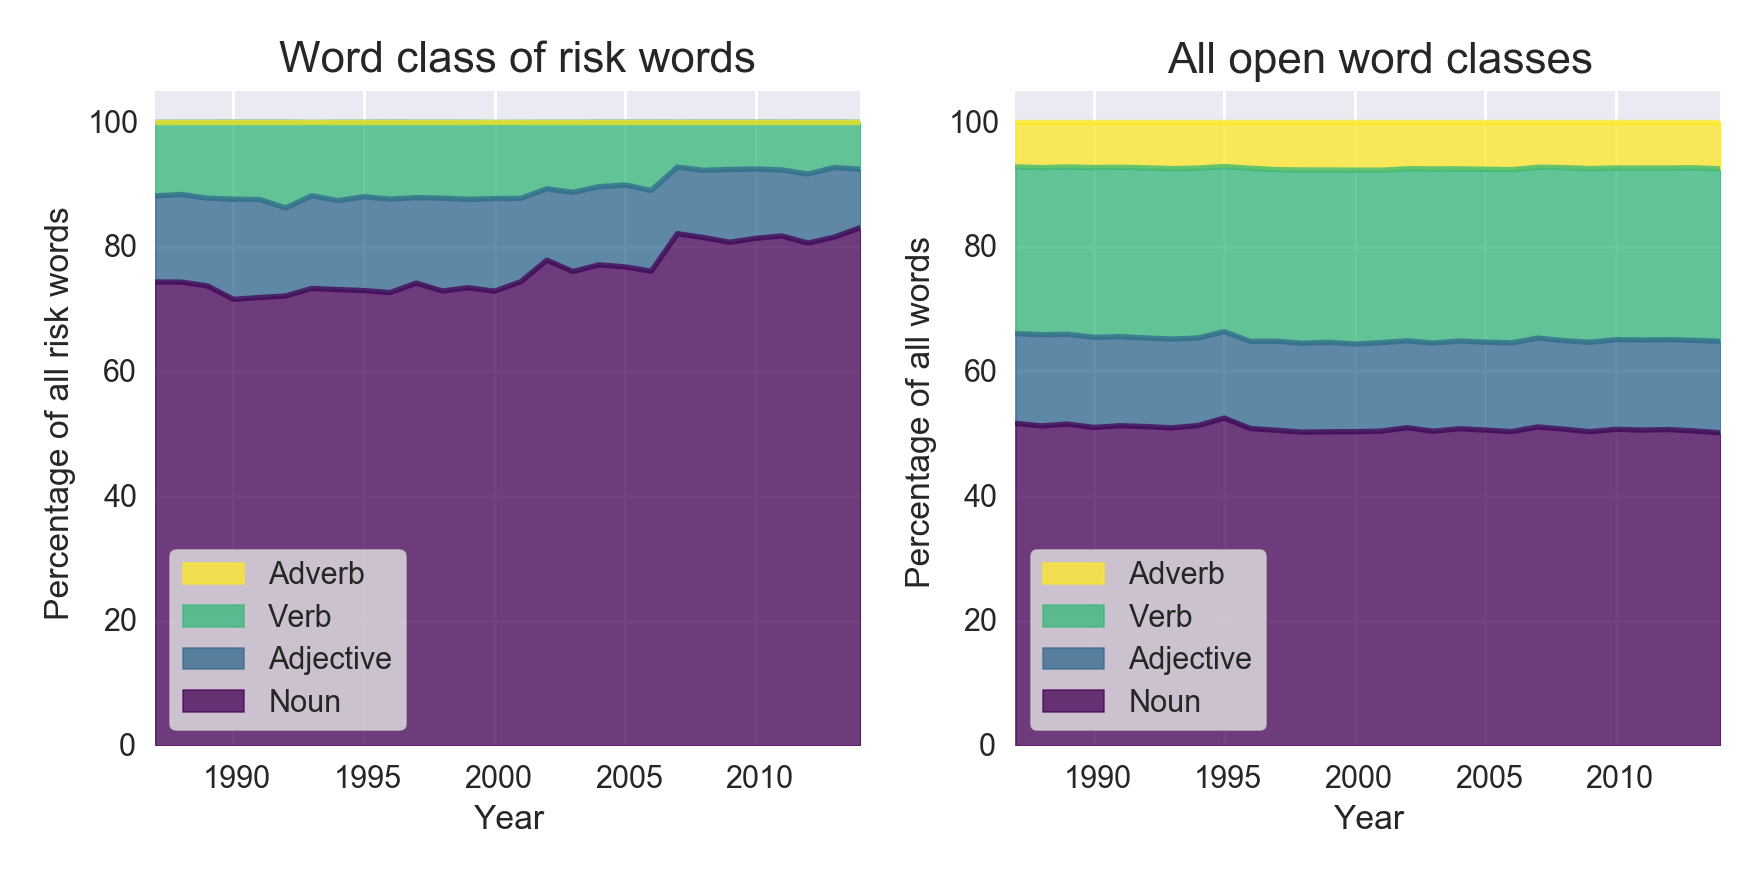

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [19]:
crp2 = crp[['Noun', 'Adjective', 'Verb', 'Adverb']]
rsk.multiplot({'title': 'Word class of risk words', 'kind': 'area', 'y_label': 'Percentage of all risk words'},
              {'title': 'All open word classes', 'data': crp2, 'kind': 'area', 'y_label': 'Percentage of all words'},
              layout=1, figsize=(8,4), split_subplots=False, **sty)

<IPython.core.display.Javascript object>


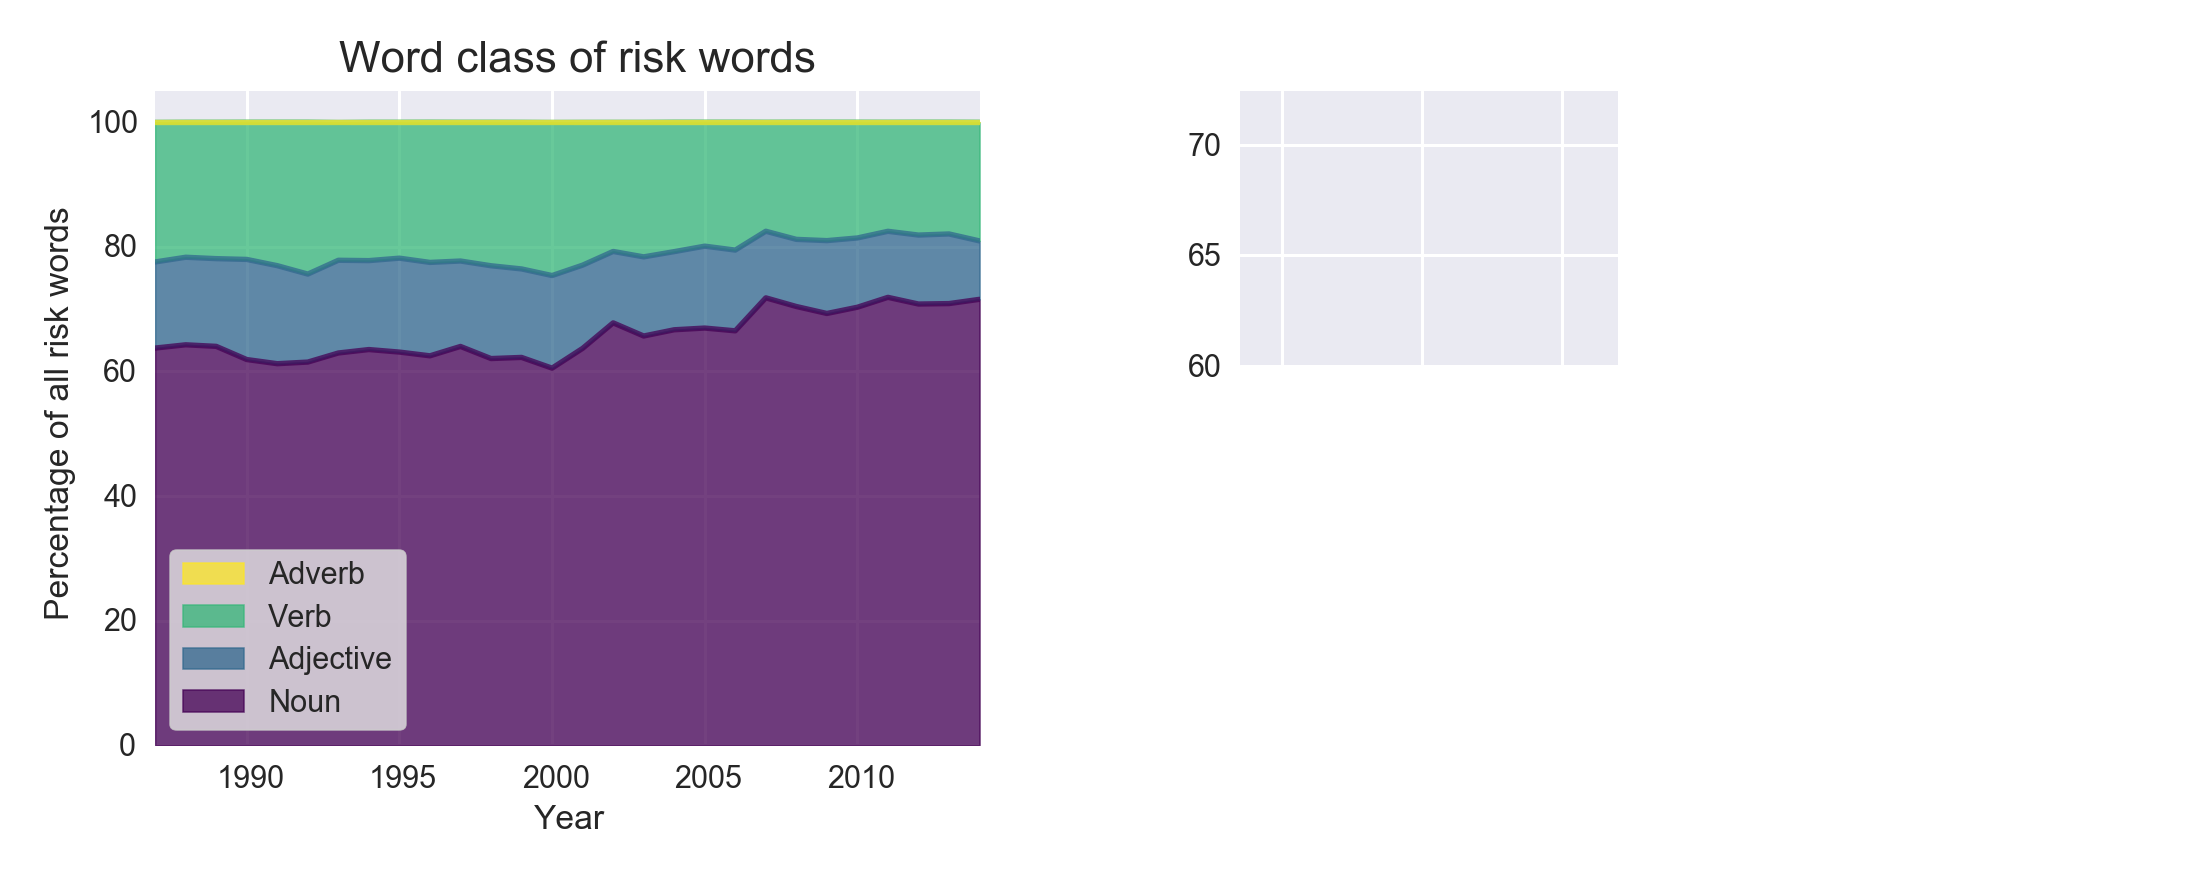

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [45]:
# shifting process risks to verbal category
rsk2 = pos.table(subcorpora='year', show='wc')
actually_proc = saved['rsk_prc'].T.drop('risk').sum()
rsk2['verb'] += actually_proc
rsk2['noun'] -= actually_proc
rsk2 = rsk2.T * 100 / rsk2.sum(axis=1)
rsk2 = rsk2.T
rsk2.columns = rsk.columns.str.title()
rsk2.multiplot({'title': 'Word class of risk words', 'kind': 'area', #'filled': True,
                'y_label': 'Percentage of all risk words'},
              {'title': 'All open word classes', 'kind': 'line', 'y_label': '% all risk words'},
              layout=4, figsize=(10,4), **sty)

### Unique risk words

In [47]:
res = loaded[loaded.w.str.contains(r'\brisk')]
res = res.table(subcorpora='year', show='w')
res = res.applymap(lambda x: 1 if x else 0).sum(axis=1)
res.visualise('Unique risk words', y_label='Number of unique risk words', **sty)

NameError: name 'loaded' is not defined

In [ ]:
# general unique count
den = loaded.table(subcorpora='year', show='w')
den = den.applymap(lambda x: 1 if x else 0).sum(axis=1)
rel = res * 100 / den
rel.visualise('Unique risk words / all unique words',
              y_label='Percentage of all unique words', **sty)

## Risk processes

<IPython.core.display.Javascript object>


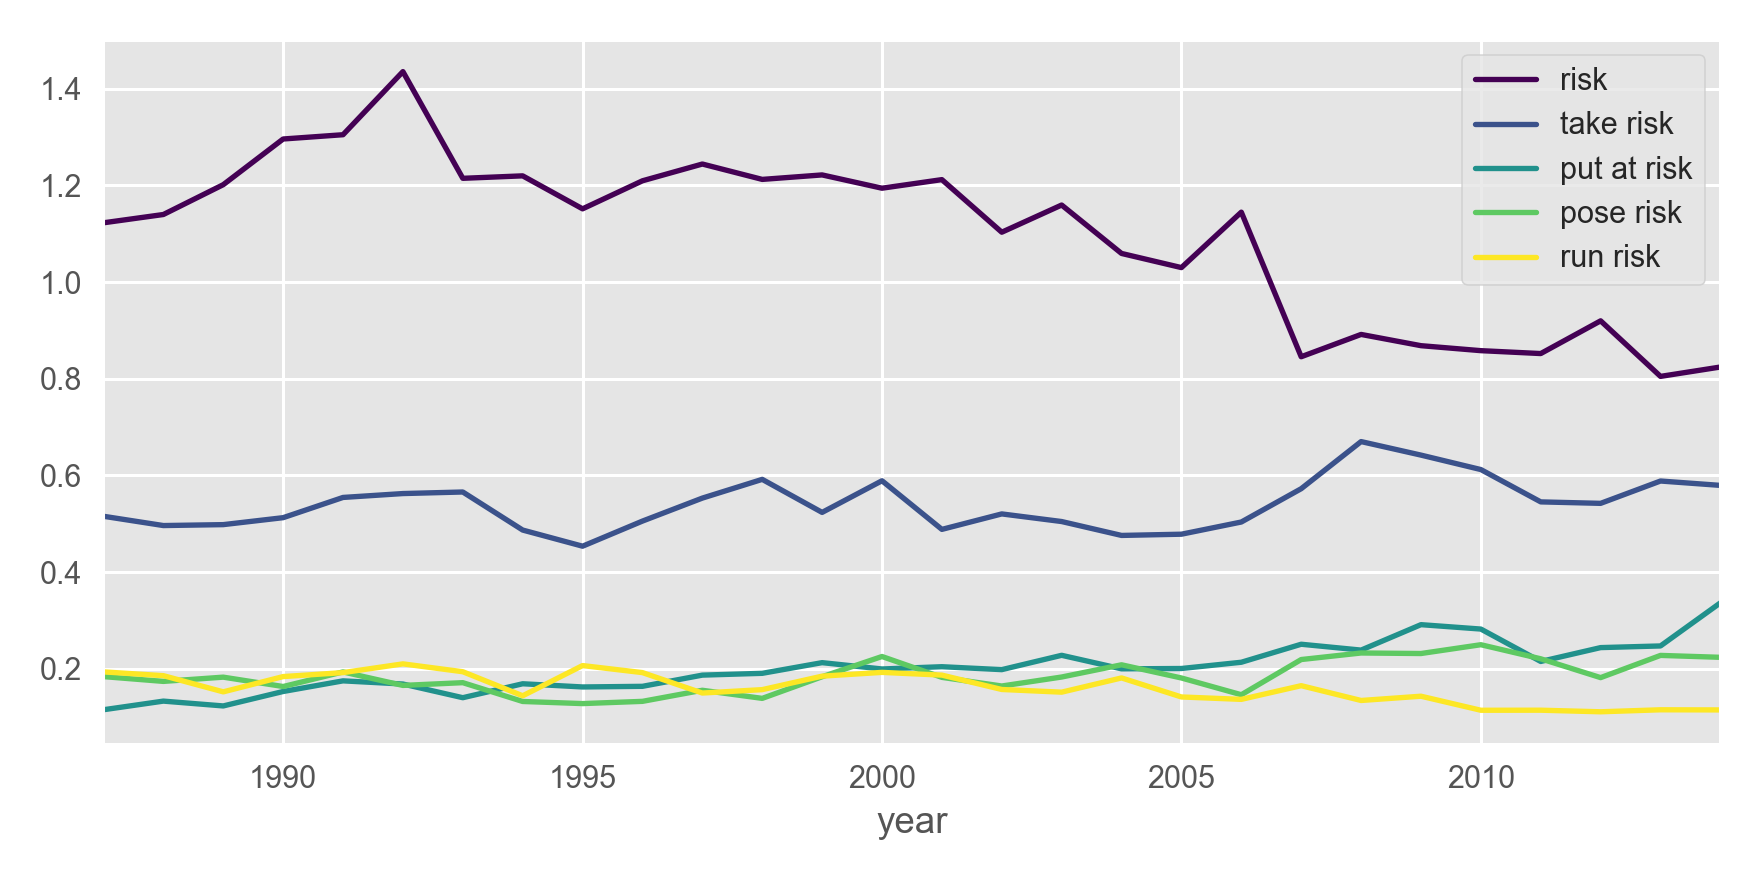

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [154]:
proc = saved['rsk_prc'].T
res = proc * 100 / feat['Clauses']
res.T.visualise(kind='line', **sty)

<IPython.core.display.Javascript object>


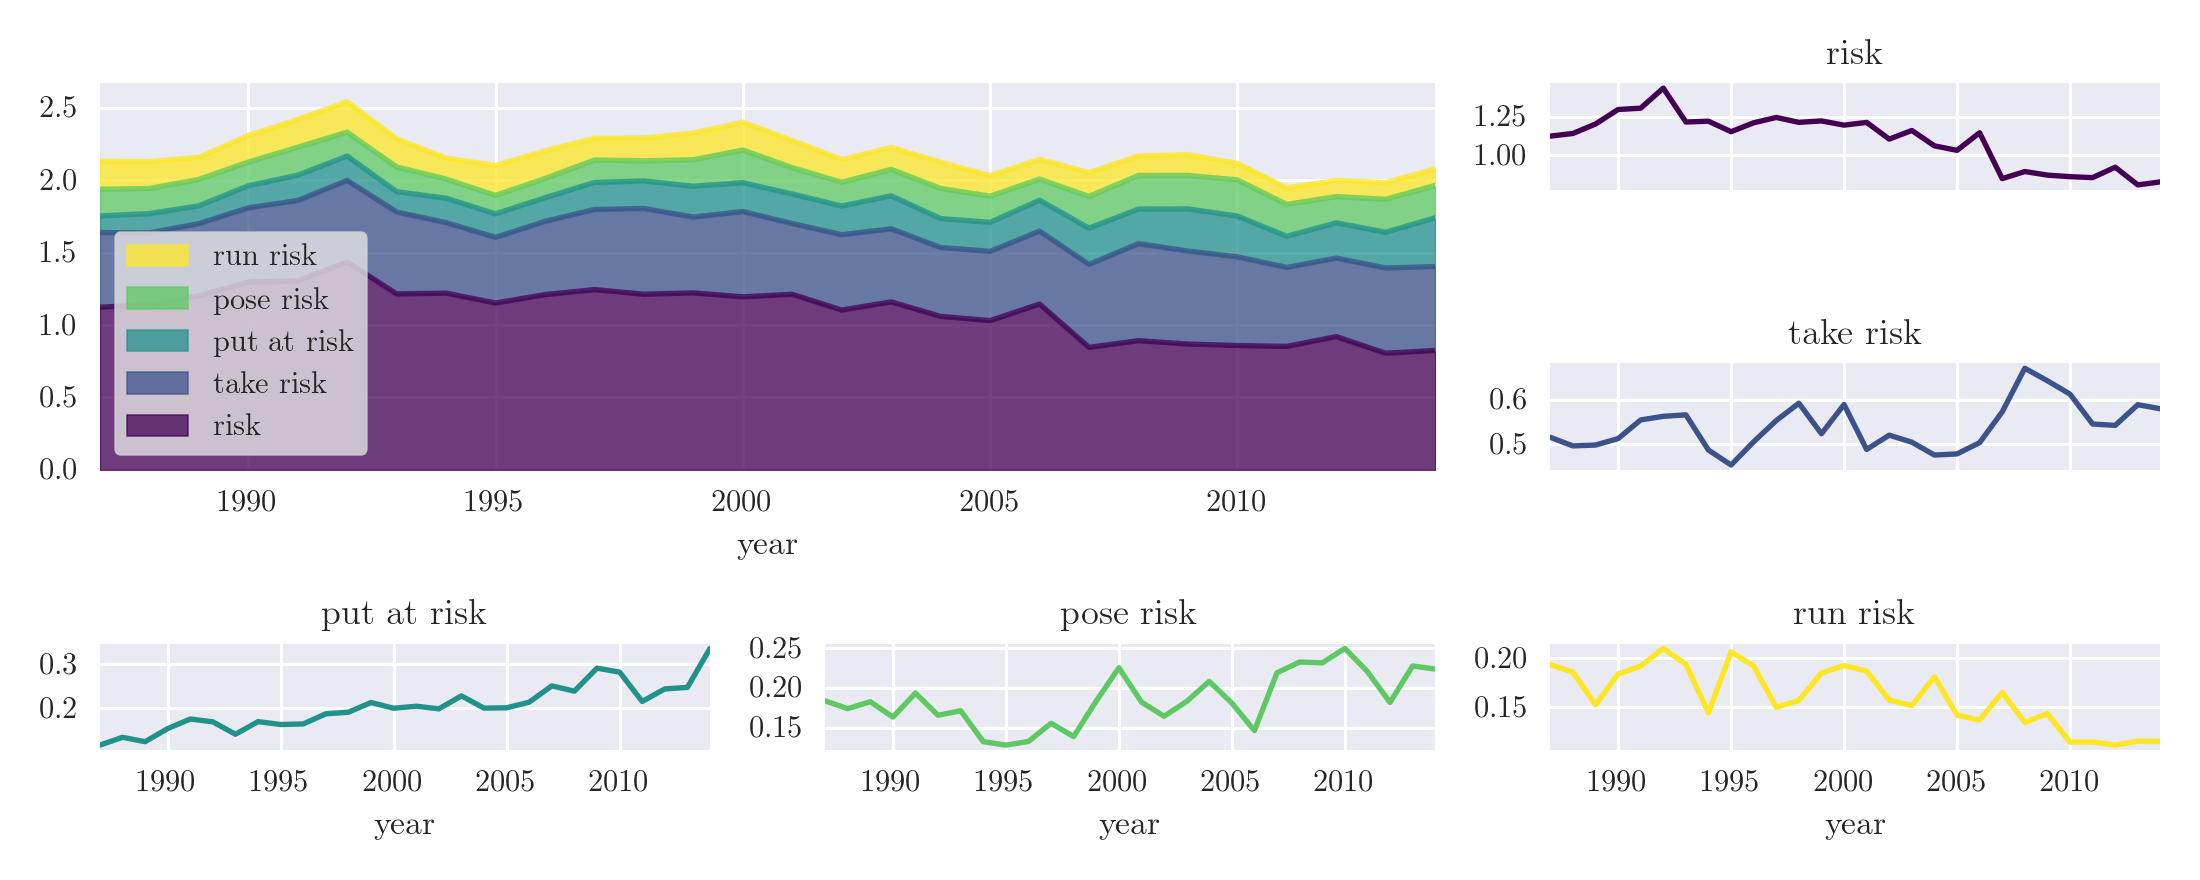

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [161]:
res.T.multiplot({}, {}, layout=5, **sty)

In [ ]:
proc = saved['rsk_prc']
riskwords = saved['rskword']
process = {'ccomp', 'prt', 'cop', 'advcl', 'root', 'aux', 'auxpass', 'acl', r'acl(_|:)relcl'}
rp = riskwords[riskwords.f.isin(process)].table(subcorpora='year').sum(axis=1)
proc['risk'] = rp
proc = proc.T
#res = proc * 100 / feat['Clauses'].drop(1963)
res = proc * 100 / proc.sum()
res.T.visualise(kind='line',**sty)

<IPython.core.display.Javascript object>


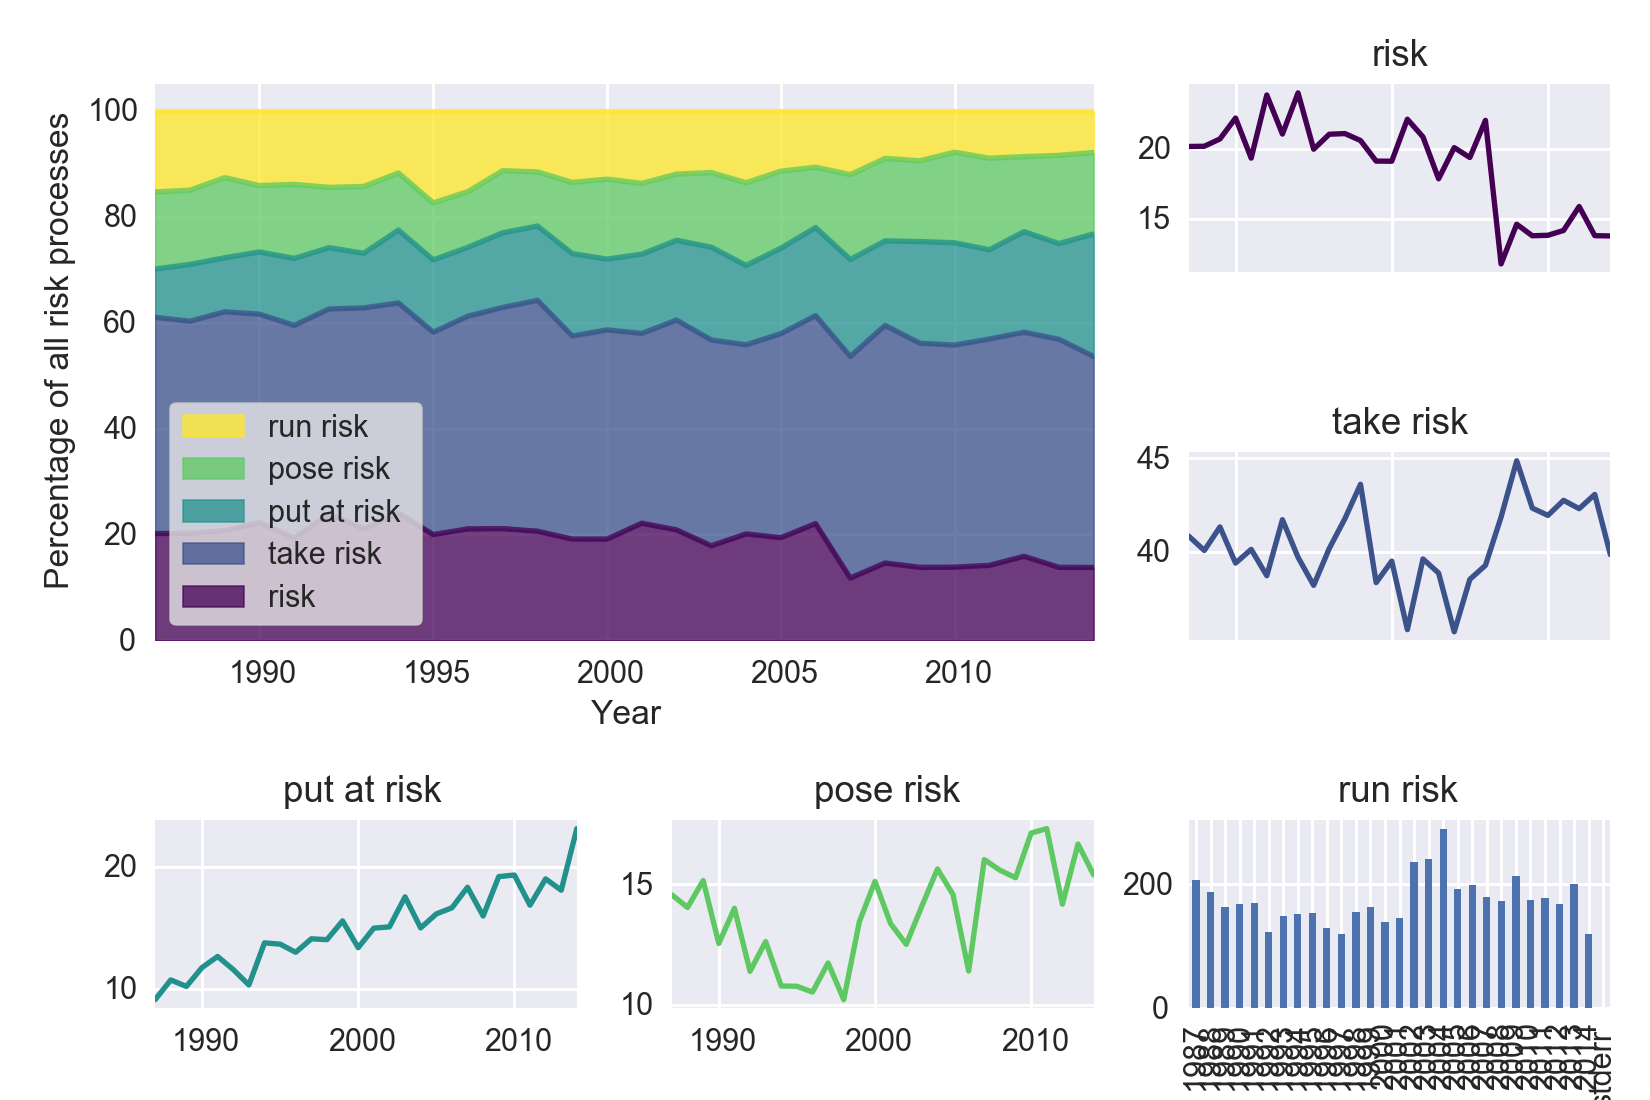

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [52]:
res.T.multiplot({'y_label': 'Percentage of all risk processes', 'legend_pos': 'lower left'},
                {'x_label': ' '},
                layout=5, figsize=(7.5, 5), **sty)

<IPython.core.display.Javascript object>


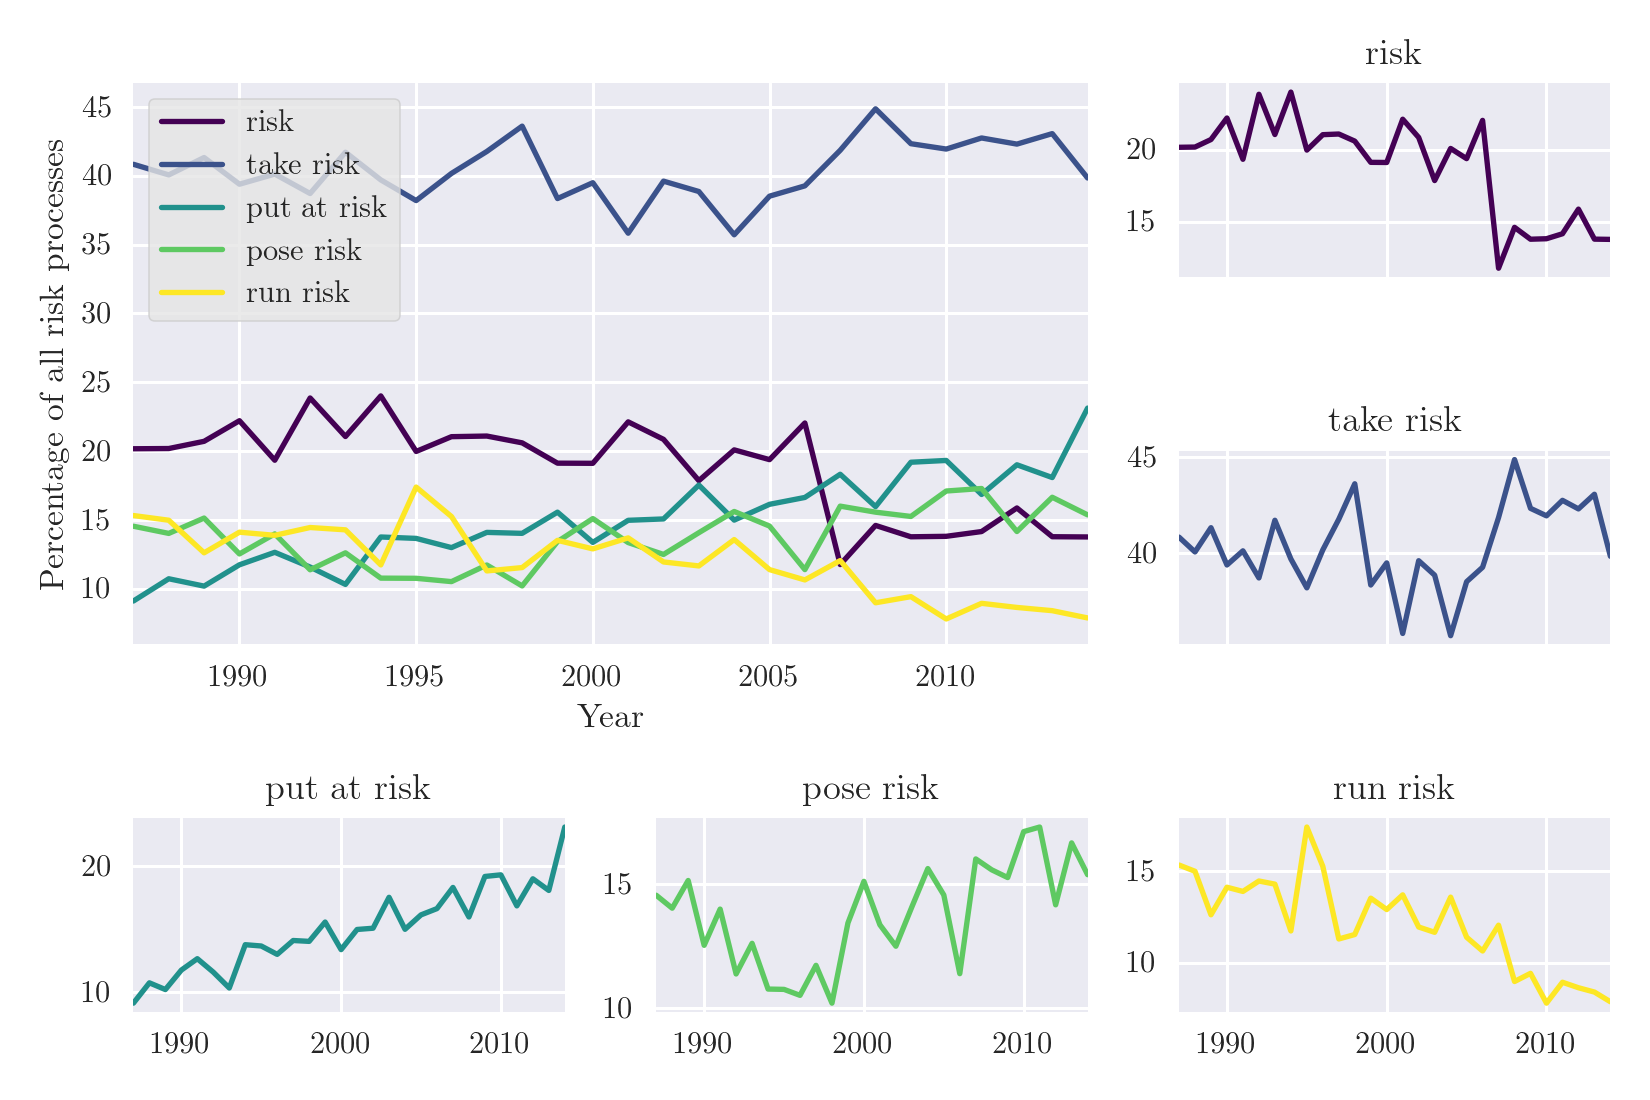

In [41]:
res.T.multiplot({'kind': 'line', 'y_label': 'Percentage of all risk processes',
                 'legend_pos': 'upper left'},
                {'x_label': ' '},
                layout=5, figsize=(7.5, 5), **sty)

In [ ]:
## Riskers
riskers = saved['r_t_risk']

In [58]:
saved.keys()

['/adj_mod',
 '/nom_dep',
 '/nom_mod',
 '/nom_rsk',
 '/riskeds',
 '/riskers',
 '/rsk_dob',
 '/rsk_prc',
 '/rsk_sbj',
 '/rsknoun',
 '/rskword']

In [138]:
#adjm = saved.adj_mod.table('year', show='l')
adjm.columns = adjm.columns.str.replace('er$', '')
adjm = adjm.groupby(axis=1, level=0).sum()
adjm = adjm[adjm.sum().sort_values(ascending=False).index]
#from corpkit.interrogation import _sort
pd.DataFrame.sort = _sort
wstat = adjm.sort(by='increase', keep_stats=True)
wstat.head()

,potential,systemic,increase,more,low,excessive,high,much,big,significant,...,considerable,negligible,bad,special,minimal,coronary,greatest,good,poor,genuine
1987,27.0,0.0,48.0,22.0,40.0,5.0,207.0,15.0,23.0,32.0,...,21.0,2.0,5.0,5.0,13.0,0.0,42.0,5.0,6.0,4.0
1988,28.0,2.0,74.0,25.0,39.0,8.0,187.0,7.0,26.0,46.0,...,21.0,5.0,7.0,12.0,15.0,4.0,40.0,11.0,11.0,19.0
1989,36.0,0.0,113.0,32.0,32.0,13.0,164.0,12.0,38.0,44.0,...,9.0,8.0,6.0,8.0,10.0,3.0,24.0,5.0,8.0,7.0
1990,24.0,0.0,60.0,29.0,30.0,9.0,168.0,5.0,27.0,30.0,...,17.0,5.0,5.0,10.0,6.0,5.0,29.0,15.0,14.0,2.0
1991,16.0,3.0,64.0,29.0,40.0,1.0,170.0,9.0,20.0,31.0,...,18.0,4.0,12.0,6.0,5.0,1.0,33.0,20.0,17.0,22.0


In [139]:
saved.keys()

['/adj_mod',
 '/nom_dep',
 '/nom_mod',
 '/nom_rsk',
 '/riskeds',
 '/riskers',
 '/rsk_dob',
 '/rsk_prc',
 '/rsk_sbj',
 '/rsknoun',
 '/rskword']

## Participants in risk process

### Riskers

In [ ]:
subj = saved['r_t_rsk']
res = subj.table('year', show='l')
res.summary()

### Object of risk

In [151]:
res = saved['riskeds']
res = res.table('year', show='l').drop(['it'], axis=1)
res.summary()

,N,%
life,2393,15.393027
injury,355,2.283546
loss,289,1.858999
it,265,1.704619
death,214,1.376560
everything,184,1.183584
money,178,1.144989
wrath,170,1.093529
career,164,1.054934
damage,159,1.022771


## Processes with risk participants

### When subject is risk

In [150]:
subj = saved['rsk_sbj']
res = subj.table('year', show='l').drop('be', axis=1)
res.summary()

,N,%
increase,428,5.561331
remain,307,3.989085
outweigh,268,3.482328
say,262,3.404366
seem,260,3.378378
rise,241,3.131497
become,233,3.027547
come,206,2.676715
go,181,2.351871
have,165,2.143971


### When object is risk

In [142]:
subj = saved['rsk_dob']
res = subj.table('year', show='l').drop(['take', 'pose', 'run'], axis=1)
res

,reduce,increase,have,carry,face,minimize,raise,assess,outweigh,create,...,overcorrect,overblow,outstrip,outsize,outmarch,organize,orchestrate,offend,obscurb,macro
year,,,,,,,,,,,,,,,,,,,,,
1987,191,96,62,45,49,22,13,22,10,18,...,0,0,0,0,1,0,0,0,0,0
1988,187,104,57,53,29,43,19,18,19,26,...,0,0,0,0,0,0,0,0,0,0
1989,197,158,64,54,40,40,19,25,26,24,...,0,0,0,0,0,0,0,1,1,0
1990,172,120,81,50,61,36,23,23,28,21,...,0,0,0,0,0,0,0,0,0,0
1991,176,122,83,58,37,34,17,16,15,20,...,0,0,0,0,0,0,0,0,0,0
1992,159,74,66,64,56,29,17,21,13,22,...,0,0,0,0,0,1,0,0,0,0
1993,163,91,75,75,33,37,17,24,21,20,...,0,0,0,0,0,0,0,0,0,0
1994,151,103,86,52,52,38,22,23,19,13,...,0,0,0,0,0,0,0,0,0,0
1995,204,117,76,80,58,36,19,24,16,17,...,0,0,0,0,0,0,0,0,0,0


## When risk is a modifier, what is being modified?

In [ ]:
mod = saved['rsknoun']

### At risk things

In [34]:
ar = saved['at_risk']

In [37]:
ar.table('year', show='l').summary()

,N,%
child,147,16.153846
student,126,13.846154
youth,123,13.516484
kid,32,3.516484
population,31,3.406593
family,24,2.637363
teenager,22,2.417582
people,18,1.978022
patient,17,1.868132
group,15,1.648352


## Risked things and potential harm

In [2]:
# get a list of all words that may be either risked things or potential harm
df = saved['potharm'].T
# top 200 results
list(df.columns[:200])

['health',
 'life',
 'it',
 'security',
 'cancer',
 'credit',
 'they',
 'that',
 'safety',
 'heart',
 'high',
 'injury',
 'greater',
 'downside',
 'great',
 'low',
 'flight',
 'investment',
 'factor',
 'percent',
 'people',
 'loss',
 'market',
 'management',
 'he',
 'higher',
 'business',
 'small',
 'money',
 'death',
 'currency',
 'this',
 'child',
 'inflation',
 'breast',
 'disease',
 'career',
 'everything',
 'capital',
 'real',
 'war',
 'attack',
 'worth',
 'group',
 'reputation',
 'damage',
 'wrath',
 'lower',
 'minimal',
 'those',
 'job',
 'themselves',
 'asset',
 'arrest',
 'risk',
 'patient',
 'rate',
 'bond',
 'strategy',
 'behavior',
 'fine',
 'one',
 'woman',
 'lifetime',
 'suicide',
 'assessment',
 'future',
 'interest',
 'loan',
 'what',
 'insurance',
 'fire',
 'control',
 'fund',
 'default',
 'company',
 'limb',
 'possibility',
 'mr.',
 'confrontation',
 'country',
 'failure',
 'stock',
 'backlash',
 'less',
 'part',
 'all',
 'problem',
 'increase',
 'time',
 'return',
 '

In [3]:
# manual lemmatisation from these top 200 results
lem = {'lives':        'life',
       'jobs':         'job',
       'bonds':        'bond',
       'children':     'child',
       'careers':      'career',
       'fines':        'fine',
       'funds':        'fund',
       'factors':      'factor',
       'investments':  'investment',
       'loan':         'loan',
       'men':          'man',
       'women':        'woman',
       'people':       'person',
       'patients':     'patient',
       'sanctions':    'sanction',
       'students':     'student',
       'assets':       'asset',
       'troops':       'troop'}

# collapse lemmas
df = df.rename(columns=lem).groupby(axis=1, level=0).sum()

# make wordlists: three categories that emerge from the data
ambig = ['it', 'that', 'high', 'greater', 'great', 'low', 'them', 'percent', 'management', 'higher', 'small', 'factors', 'they', 'this', 'he', 'real', 'lower', 'minimal', 'themselves', 'what', 'one', 'strategy', 'those', 'interest-rate', 'interest', 'mr.', 'possibility', 'him', 'control', 'less', 'behavior', 'assessment', 'part', 'more', 'groups', 'significant', 'you', 'greatest', 'himself', 'taking', 'system', '1', 'trading', 'enormous', 'highest', 'negligible', 'approach', 'decision', 'acceptable', 'lending', 'exchange', 'plan', 'slight', 'arbitrage', 'price', 'concern', 'i', 'group', 'substantial', 'public', 'chance', 'clear', 'her', 'move', 'policy', 'there', 'action', 'kind', 'time', 'same', 'the', 'increase', 'likely', 'proces', 'own', 'reason', 'event', 'drug', 'these', 'fracture', 'different', 'students', 'rabbi', 'fund', 'aversion', 'analysis', 'americans']
riskd = ['health', 'lives', 'security', 'child', 'life', 'credit', 'heart', 'insurance', 'assets', 'safety', 'investment', 'business', 'capital', 'everything', 'reputation', 'market', 'people', 'money', 'currency', 'children', 'career', 'limb', 'women', 'jobs', 'patients', 'liquidity', 'nothing', 'soldiers', 'job', 'economy', 'stocks', 'funds', 'careers', 'credibility', 'company', 'troops', 'dollars', 'country', 'investments', 'worth', 'lifetime', 'bonds', 'failure', 'radiation', 'securities', 'loans', 'rate', 'future', 'all', 'anything', 'something', 'return', 'government', 'research', 'change', 'climate', 'program', 'men', 'companies', 'portfolio', 'operation']
harms = ['cancer', 'breast', 'disease', 'inflation', 'suicide', 'fire', 'downside', 'injury', 'flight', 'loss', 'death', 'war', 'damage', 'wrath', 'attack', 'arrest', 'default', 'criticism', 'recession', 'mortality', 'backlash', 'danger', 'conflict', 'surgery', 'problems', 'humiliation', 'flood', 'disaster', 'sanctions', 'casualties', 'penalties', 'debt', 'crisis', 'execution', 'losses', 'collapse', 'earthquake', 'prosecution', 'infection', 'litigation', 'ire', 'fine', 'embarrassment', 'exposure', 'fines', 'confrontation', 'stroke', 'defeat', 'liability', 'harm', 'rollover', 'consequences']

# auto-cleanup the word lists
riskd = [lem.get(i, i) for i in riskd if lem.get(i, i) in df.columns]
harms = [lem.get(i, i) for i in harms if lem.get(i, i) in df.columns]

In [4]:
risked = df[list(set(riskd))].sort('total')
harm = df[list(set(harms))].sort('total')

In [5]:
risked.summary(25)

,N,%
health,3033,20.355705
life,2811,18.865772
security,1259,8.449664
credit,668,4.483221
safety,514,3.449664
heart,503,3.375839
investment,365,2.449664
person,353,2.369128
market,320,2.147651
business,284,1.906040


<IPython.core.display.Javascript object>


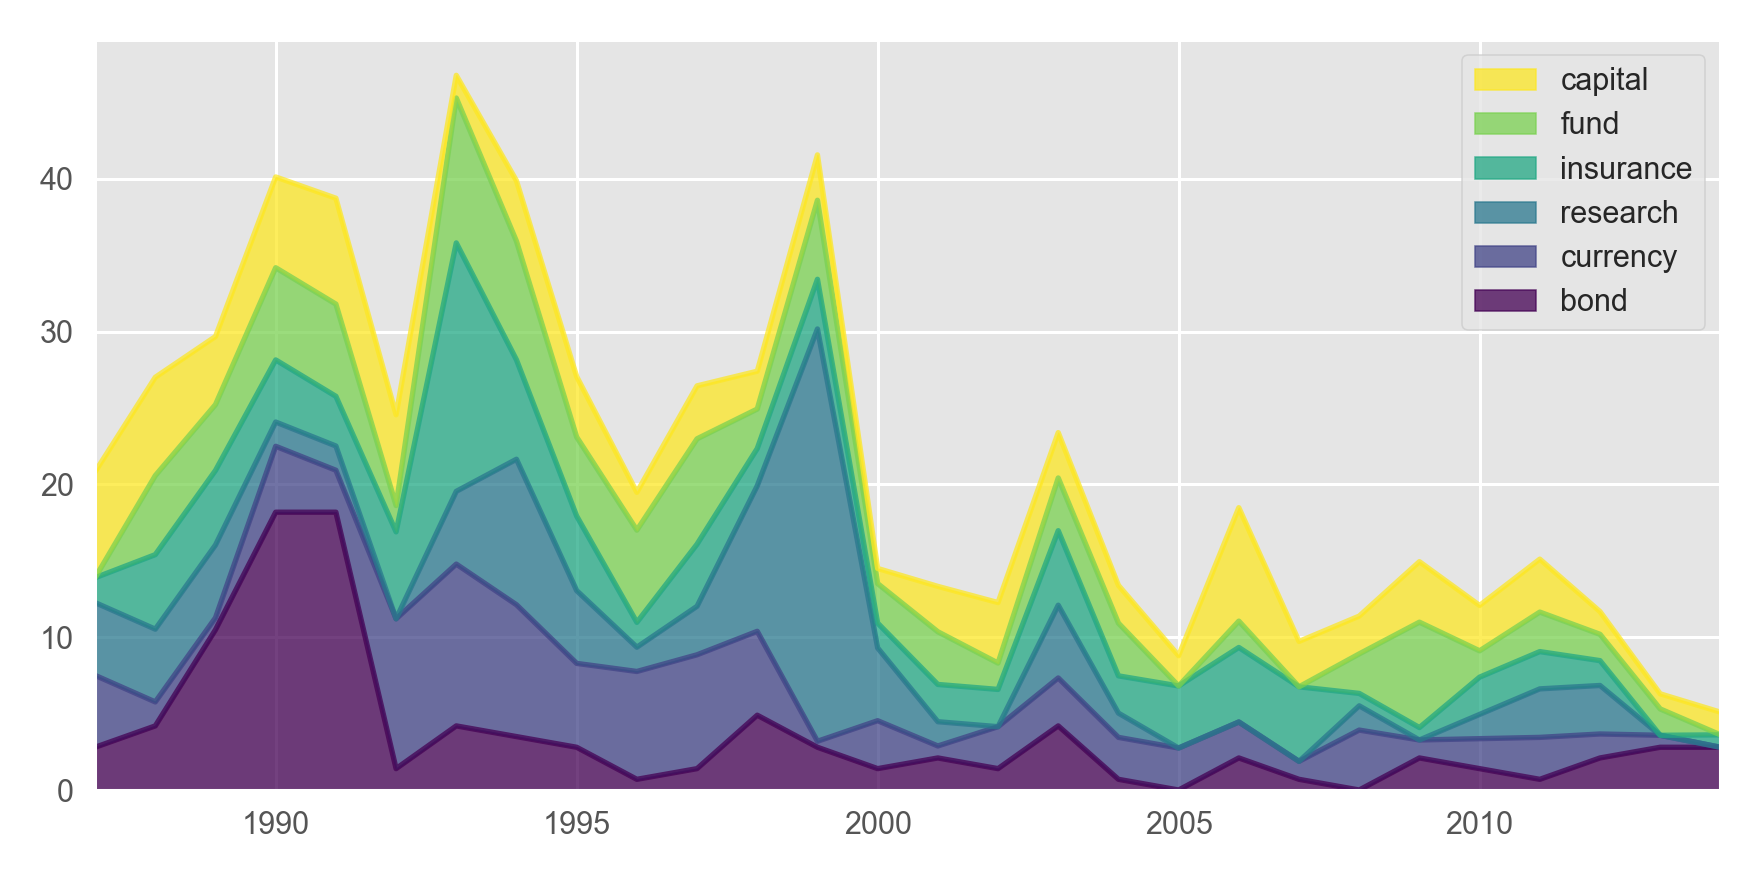

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [8]:
df = risked * 100.0 / risked.sum()
df = df[.sort('decrease')]
df.visualise(kind='area', **sty)

In [50]:
harm.summary()

,N,%
cancer,1038,15.590267
downside,424,6.368279
injury,404,6.067888
flight,359,5.392010
loss,269,4.040252
death,248,3.724842
inflation,225,3.379393
breast,220,3.304296
disease,216,3.244217
war,177,2.658456


<IPython.core.display.Javascript object>


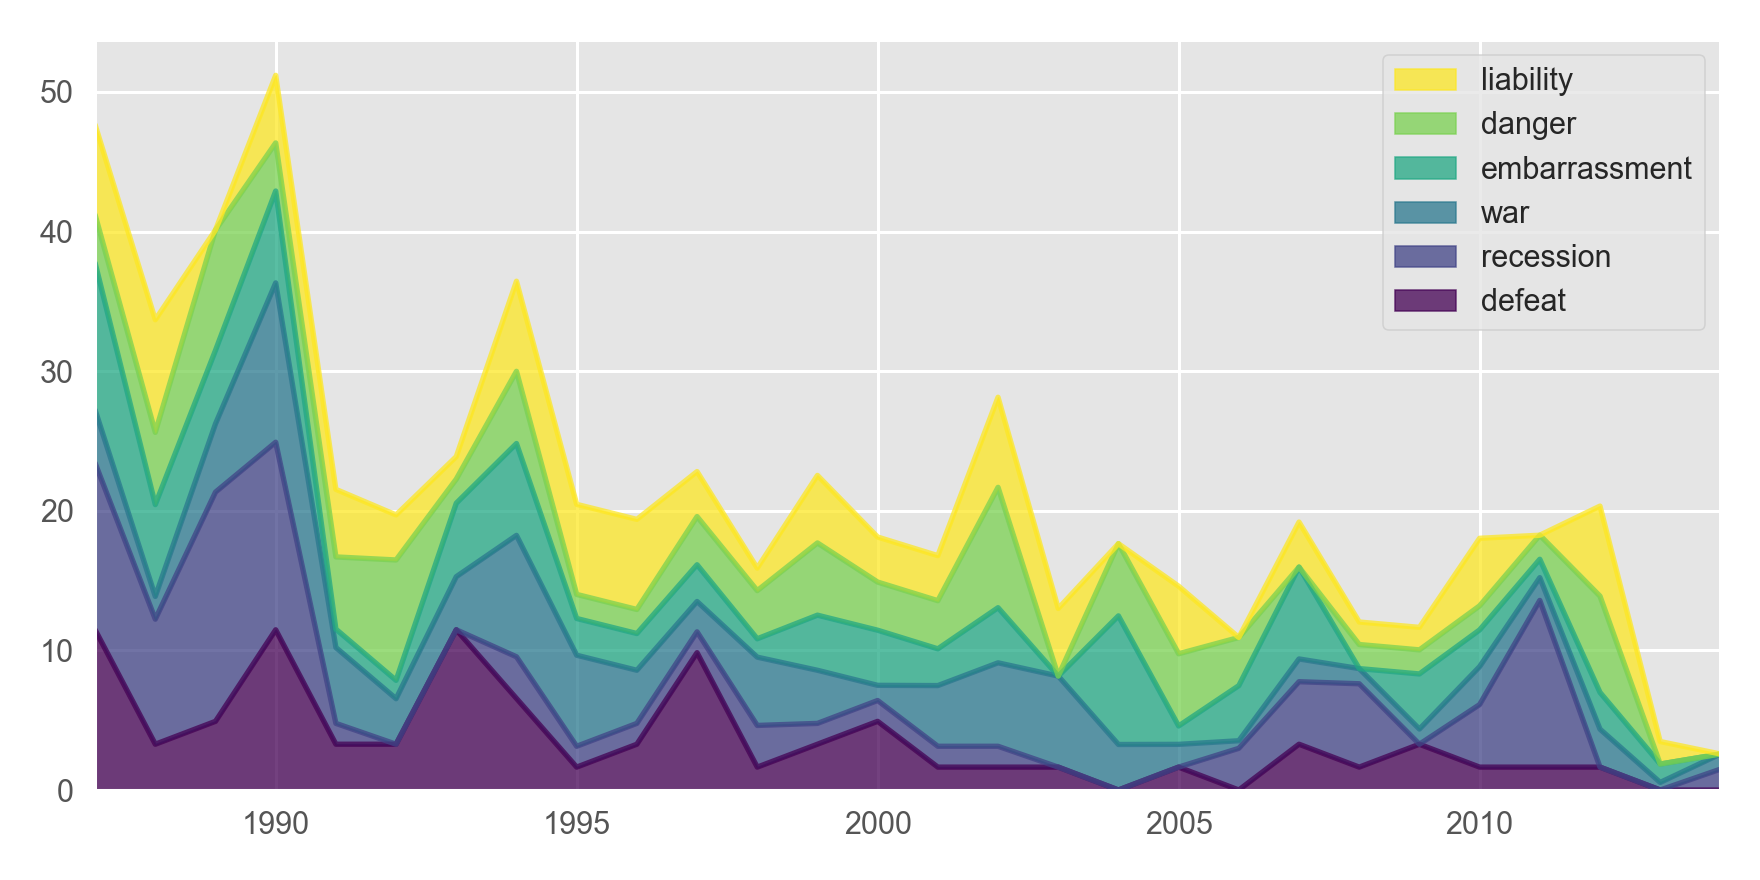

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [10]:
df = harm * 100.0 / harm.sum()
df = df.sort('decrease')
df.visualise(kind='area', **sty)

## Historical data

In [16]:
d = "all articles,risk,danger,harm,threat,uncertainty,chance,safety,security,certainty,\n1852,18670,270,565,87,96,58,464,483,541,150,\n1853,22495,688,684,111,162,85,519,712,539,223,\n1854,20400,366,763,148,162,83,478,683,625,242,\n1855,18336,303,750,169,105,77,513,464,553,175,\n1856,18162,211,656,101,112,52,416,533,449,146,\n1857,18168,249,661,149,100,73,442,483,530,147,\n1858,17388,330,599,134,116,78,455,510,509,150,\n1859,14595,284,563,150,90,72,398,532,469,141,\n1860,19288,313,838,208,178,100,632,705,551,229,\n1861,27011,363,1149,255,181,103,611,945,501,248,\n1862,25181,318,963,297,111,109,554,761,412,244,\n1863,21104,277,841,214,131,90,583,712,397,245,\n1864,20435,280,771,193,130,74,569,632,405,229,\n1865,22727,245,636,199,114,70,471,554,386,198,\n1866,20556,302,897,197,170,78,529,650,554,154,\n1867,21310,307,839,245,137,102,541,593,551,165,\n1868,23705,261,773,220,133,74,474,422,490,140,\n1869,29660,246,462,84,83,39,218,332,334,90,\n1870,26553,249,763,179,123,71,382,497,441,121,\n1871,29861,383,1005,259,177,106,918,795,540,262,\n1872,34046,385,892,302,131,108,953,624,403,340,\n1873,35416,397,991,298,132,120,876,776,545,265,\n1874,40519,410,952,405,205,141,941,668,478,248,\n1875,37590,430,831,378,199,115,884,614,492,250,\n1876,39010,379,792,286,159,119,724,493,511,321,\n1877,42743,447,820,307,169,160,735,524,603,213,\n1878,47106,513,1085,379,200,155,1047,573,735,282,\n1879,48730,589,1213,370,243,179,1314,749,567,357,\n1880,45118,545,1337,351,194,180,1344,741,549,333,\n1881,47627,542,1345,418,208,191,1247,760,549,333,\n1882,49116,507,1108,417,196,166,1263,720,539,294,\n1883,57869,488,1088,443,232,151,1456,765,449,270,\n1884,59113,511,1316,419,240,211,1598,745,593,303,\n1885,57848,565,1304,452,235,183,1609,685,567,271,\n1886,57657,498,1168,411,239,175,1684,617,488,276,\n1887,57086,556,1216,386,233,170,1556,608,441,327,\n1888,58706,441,1155,395,204,131,1368,609,382,317,\n1889,57418,437,1121,335,150,113,1213,686,294,280,\n1890,47820,431,1398,410,212,187,2061,721,494,361,\n1891,48887,481,1561,447,256,190,2083,812,543,347,\n1892,53545,514,1940,469,281,251,2325,1017,597,433,\n1893,45467,481,1827,499,286,362,2378,1073,853,422,\n1894,45699,533,1794,488,254,452,2352,999,796,450,\n1895,67229,664,2016,588,261,260,2461,1134,679,437,\n1896,54732,471,1646,461,320,305,2012,949,586,338,\n1897,61912,495,1834,489,248,250,1921,908,608,312,\n1898,65543,742,2117,531,236,316,2205,1074,691,354,\n1899,66607,619,1972,560,267,263,2252,965,723,377,\n1900,70431,622,2186,530,282,321,2462,1435,879,407,\n1901,67227,580,2138,584,330,320,2316,1229,870,413,\n1902,66878,563,2033,561,279,331,2345,1414,793,384,\n1903,67926,643,2201,639,353,329,2572,1384,813,409,\n1904,59485,629,1900,477,349,268,2304,1149,633,318,\n1905,57257,513,1655,462,328,197,2267,955,577,298,\n1906,53401,506,1718,467,333,248,2512,890,645,324,\n1907,61579,471,1777,489,314,257,2544,1040,760,285,\n1908,59545,485,1746,551,366,285,2562,933,686,334,\n1909,59021,517,1838,519,298,265,2513,978,536,277,\n1910,66868,587,2133,624,353,345,3039,1155,538,371,\n1911,64042,645,2209,545,431,388,2989,1318,725,357,\n1912,69781,704,2349,593,439,409,3470,1622,759,449,\n1913,69255,725,2246,628,471,430,3224,1623,944,377,\n1914,74122,902,2608,554,538,455,3131,1753,967,422,\n1915,74539,867,2871,600,662,428,3160,2009,1101,452,\n1916,66211,809,2649,503,663,397,2784,1569,1011,446,\n1917,74861,782,2426,572,630,472,2612,1600,1158,481,\n1918,73161,720,2508,551,533,314,2312,1318,1107,431,\n1919,78303,778,2458,481,801,499,2818,1346,1121,391,\n1920,88803,717,2182,539,793,489,3258,1231,1024,399,\n1921,102440,786,2408,593,743,504,3176,1534,1215,419,\n1922,108570,761,2581,716,838,521,3491,1714,1231,488,\n1923,85718,784,2683,603,800,621,3923,1838,1490,469,\n1924,87066,841,2507,573,713,661,3990,1803,1557,422,\n1925,98043,847,2827,621,795,564,3894,1937,2022,443,\n1926,125253,850,2947,623,897,652,4194,2046,1308,527,\n1927,159814,893,2923,582,988,664,4331,2448,1475,428,\n1928,162125,918,2852,696,997,697,4679,2877,1898,464,\n1929,168708,933,2871,794,1120,765,4180,2867,2323,503,\n1930,168795,899,3119,653,1312,931,4138,2968,2777,521,\n1931,165521,986,3118,696,1396,979,4229,2629,2943,486,\n1932,141547,957,2879,659,1565,1066,4071,2302,3369,540,\n1933,157423,874,2765,597,1731,1241,3728,2022,3192,455,\n1934,168475,874,2822,531,1984,1075,3950,2133,3216,416,\n1935,169222,1093,2893,566,2209,1342,3873,2482,4297,422,\n1936,173489,1040,3280,475,2305,933,4128,2879,4534,442,\n1937,169383,1013,3191,621,2340,830,4255,3044,3969,446,\n1938,156593,1069,2981,570,2360,860,4147,2707,4045,396,\n1939,160706,1428,3121,533,2602,921,4003,2975,4588,485,\n1940,156713,1315,3305,542,2697,687,4135,2995,4243,469,\n1941,168863,1167,3192,502,2984,580,3587,2521,3797,407,\n1942,153796,1073,2573,530,2239,470,3148,2263,2968,354,\n1943,140362,890,2050,417,2021,432,2897,1726,2880,323,\n1944,134003,861,1934,397,1886,370,2916,1465,3344,318,\n1945,126423,760,2037,434,1878,464,2931,1647,4708,329,\n1946,143531,917,2391,486,2720,652,3721,2200,6415,340,\n1947,155235,995,2449,510,2674,630,3556,2514,5612,362,\n1948,154455,987,2255,465,2642,531,3555,2219,6272,350,\n1949,158907,1129,2258,494,2592,531,3336,2358,6313,324,\n1950,161614,1242,2781,575,3015,563,3912,2535,7911,319,\n1951,162657,1217,2712,500,2733,566,3879,2536,6615,366,\n1952,159655,1132,2224,509,2581,400,3651,2566,6607,308,\n1953,151205,1089,2250,496,2574,501,3431,2406,6896,286,\n1954,147087,1309,2188,505,2523,436,3406,2086,6537,282,\n1955,144399,1187,2125,464,2224,425,3247,2156,5736,266,\n1956,144136,1264,2514,594,2502,455,3632,2279,5699,326,\n1957,142378,1088,2455,508,2515,402,3292,2279,5079,245,\n1958,144337,1010,2068,505,2334,447,3179,2226,4548,241,\n1959,147776,968,1861,494,2444,340,3180,2111,4105,273,\n1960,145547,1112,2044,498,2633,424,3518,2245,5040,284,\n1961,141093,1212,2122,459,2819,423,3296,2125,5019,251,\n1962,138890,1285,2144,507,2807,503,3557,2092,4749,256,\n1963,115128,1173,1891,466,2287,525,3318,1854,4261,256,\n1964,136003,1219,2114,514,2629,551,3899,1963,4988,307,\n1965,120718,1109,1836,468,2280,504,3410,1866,4069,271,\n1966,130604,1333,2148,454,2511,573,4188,2674,4537,288,\n1967,122405,1326,1944,570,2655,512,4173,2318,4701,270,\n1968,120008,1401,1936,487,2594,530,3982,2106,4357,293,\n1969,109392,1438,1932,490,2510,570,3713,2189,4832,264,\n1970,102884,1468,2098,593,2744,574,4243,2636,4810,301,\n1971,94745,1563,1888,564,2571,646,4052,2203,5191,249,\n1972,96788,1516,1738,612,2504,523,4559,2374,5609,378,\n1973,98008,1728,2082,696,2983,707,4754,2720,6598,373,\n1974,97645,1795,2068,618,2827,826,4940,2633,5491,446,\n1975,96523,2075,2225,783,2975,855,4912,2887,6606,446,\n1976,92159,2120,1908,763,2822,836,5356,2510,6024,495,\n1977,92415,2351,2112,801,2677,927,5275,2720,6397,375,\n1978,65286,1832,1483,552,2219,651,4113,2122,4945,314,\n1979,81390,2342,2057,771,2703,922,4780,3178,5726,352,\n1980,81303,2498,2027,687,2791,871,5154,2882,6068,347,\n1981,95717,2468,1977,657,2936,954,4812,2999,6490,304,\n1982,96846,2489,1729,688,2761,915,4627,2551,6576,274,\n1983,102330,2565,1876,649,2629,888,4640,3018,6055,295,\n1984,107767,2727,1754,715,2687,791,5139,2863,6058,244,\n1985,104437,3002,1866,823,2725,785,5122,2919,6106,248,\n1986,107403,3205,1901,806,2745,928,5279,3144,6117,275,\n1987,104535,3454,1876,790,2757,904,5301,2795,6068,290,\n1988,103205,3388,1817,727,2590,869,5308,2887,5501,242,\n1989,101728,3591,1716,790,2667,825,5078,2900,5262,275,\n1990,97497,3808,1866,798,3026,1000,5087,2761,5616,324,\n1991,86654,3483,1652,762,2701,893,5080,2686,5146,283,\n1992,91537,3526,1734,796,2618,934,5523,2669,5303,273,\n1993,87811,3388,1676,840,2583,808,5342,2819,5497,267,\n1994,83808,3553,1684,751,2598,775,5141,2938,5048,311,\n1995,92735,3740,1810,847,2651,832,5541,3364,5445,264,\n1996,81852,3416,1697,832,2525,706,5550,3186,5270,257,\n1997,83601,3578,1597,835,2426,652,5670,2974,4768,252,\n1998,88344,4068,1761,987,2950,809,6235,3278,5535,333,\n1999,89882,4014,1776,1007,3042,719,6492,3600,5974,307,\n2000,92320,4162,1748,1003,2834,860,7013,3440,6196,364,\n2001,93821,4370,1796,1033,3358,1025,6607,3984,7718,380,\n2002,96468,4860,1947,1095,3644,1002,6608,3704,8277,380,\n2003,94838,4860,1936,1150,3856,1020,6345,3766,8712,387,\n2004,90399,4749,1805,1017,3401,836,6336,3341,8781,395,\n2005,87912,4684,1638,1005,2888,886,6142,3429,8087,372,\n2006,84778,4821,1662,1033,3057,852,5973,3262,8309,372,\n2007,81991,4767,,,,,,,,,"

In [49]:
from io import StringIO
interest = ['risk', 'threat', 'danger', 'harm', 'uncertainty']
df = pd.read_csv(StringIO(d), sep=',').fillna(0.0).astype(int).iloc[:-1][interest]
rel = df.T * 100.0 / df.T.sum()
rel = rel.T
df

,risk,threat,danger,harm,uncertainty
1852,270,96,565,87,58
1853,688,162,684,111,85
1854,366,162,763,148,83
1855,303,105,750,169,77
1856,211,112,656,101,52
1857,249,100,661,149,73
1858,330,116,599,134,78
1859,284,90,563,150,72
1860,313,178,838,208,100
1861,363,181,1149,255,103


<IPython.core.display.Javascript object>


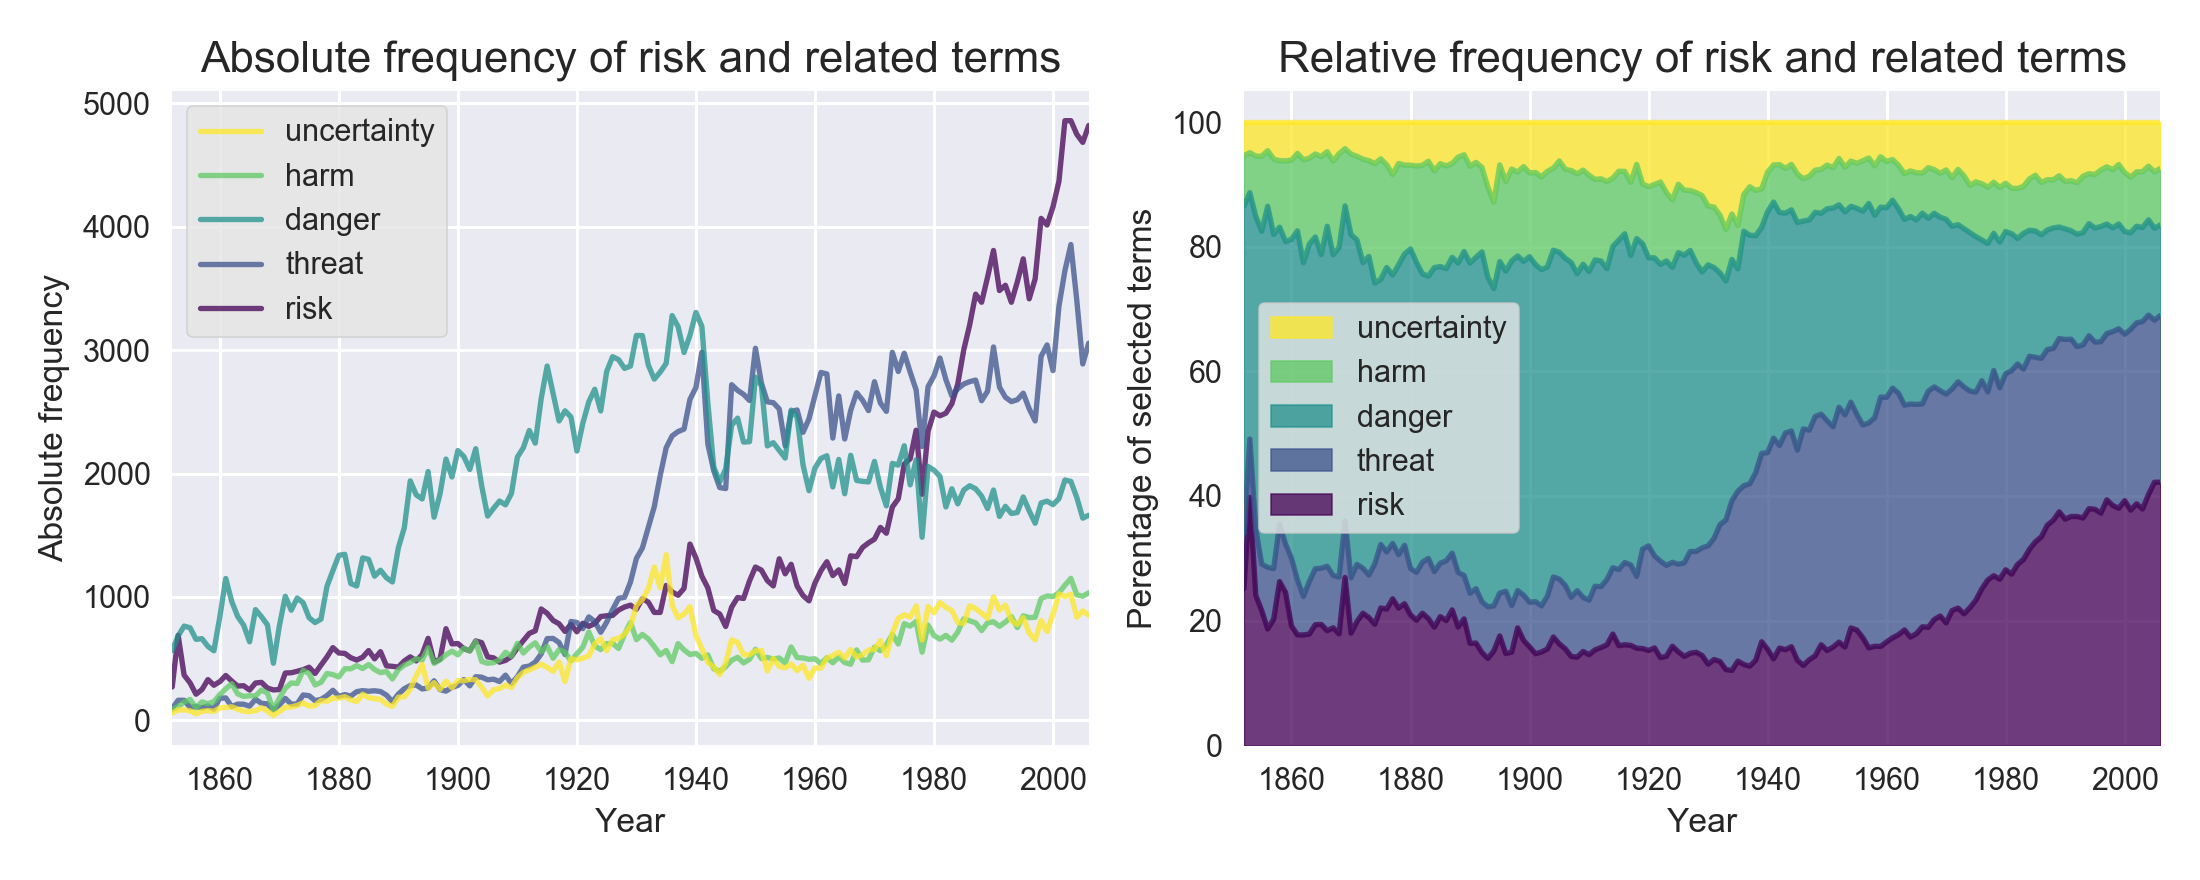

<module 'matplotlib.pyplot' from '/Users/danielmcdonald/virtenvs/py3/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/pyplot.py'>

In [76]:
df.multiplot({'kind': 'line', 'title': 'Absolute frequency of risk and related terms', 'black_and_white': False,
              'y_label': 'Absolute frequency', 'reverse_legend': True},
             {'kind': 'area', 'title': 'Relative frequency of risk and related terms', 
              'data': rel, 'y_label': 'Perentage of selected terms', 'reverse_legend': True},
             layout=1, split_subplots=False, **sty)

,risk,threat,danger,harm,uncertainty
2006,4821,3057,1662,1033,852
2005,4684,2888,1638,1005,886
2004,4749,3401,1805,1017,836
2003,4860,3856,1936,1150,1020
2002,4860,3644,1947,1095,1002
2001,4370,3358,1796,1033,1025
2000,4162,2834,1748,1003,860
1999,4014,3042,1776,1007,719
1998,4068,2950,1761,987,809
1997,3578,2426,1597,835,652
